---

<font color="green">Комментарий тимлида</font>

Привет!)
Спасибо за декомпозицию)

В целом все верно -- понятный план и достаточно подробно расписано)

Я согласна с твоим планом, можно приступать)

# Игры — Анализ рекламных источников

## Оглавление
<a id = "index"></a>

- [Описание датасетов](#desc)
- [Настройка окружения](#sett)
- [Загрузка данных](#load)
1. [Предобработка данных](#pre)
1. [Настройка окружения](#env)
1. [Загрузка данных](#first_look)
1. [Подготовка данных](#etl)
1. [Исследовательский анализ данных](#eda)
1. [Проверка гипотез](#main_hypotheses)
1. [Выводы и рекомендации](#conclusion)
1. [Ссылка на презентацию](#presentation)

### **Описание датасетов:**
<a id = "desc"></a>
[В оглавление](#index)

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет **game_actions.csv**:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи.

Датасет **ad_cost.csv**:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет **user_source.csv** содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

### Настройка окружения (загрузка библиотек)
<a id = "sett"></a>
[В оглавление](#index)

In [3]:
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

from io import BytesIO
import requests


# отображение одного знака после запятой
pd.options.display.float_format = '{:,.1f}'.format
plt.rcParams["figure.dpi"] = 160

## Загрузка данных 
<a id = "load"></a>
[В оглавление](#index)

In [8]:
spreadsheet_id = '1zYES4BhJXmI1udxHfMgLH3BGSS2_66G1gTnvO4LWlMs' #id гугл таблицы
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
events = pd.read_csv(BytesIO(r.content), sep =',')


In [10]:
events.tail(5)

,event_datetime,event,building_type,user_id,project_type
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN
135639,2020-06-05 12:32:49,finished_stage_1,NaN,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN


In [11]:
events['user_id'].nunique()

13576

In [12]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


**Вывод:**
- Есть пропуски по столбцам `building_type` и `project_type`
- `event_datetime`  требует предобразования в формат даты

In [15]:
spreadsheet_id = '1J2K9xBE4uT1GOCXgvMP2_HoKZVOr2ZcXeSyYxby6ZMA' #id гугл таблицы
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
ad_costs = pd.read_csv(BytesIO(r.content))
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.9
1,facebook_ads,2020-05-04,548.4
2,facebook_ads,2020-05-05,260.2
3,facebook_ads,2020-05-06,178.0
4,facebook_ads,2020-05-07,111.8


In [16]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


**Вывод:**
- `day`  требует предобразования в формат даты

In [17]:
spreadsheet_id = '1b9HFYLcPk8knlCe7FA0aXGcxCAty7yS2ciSREBKCD-4' #id гугл таблицы
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
user_source = pd.read_csv(BytesIO(r.content))
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [18]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


**Вывод:**
- Преобразования не требуются предобразования в формат даты

## 1. Предобработка данных
<a id = "pre"></a>
[В оглавление](#index)

### 1.1. Проверка данных на пропуски

##### Проверим пропуски по столбцу `building_type`

In [19]:
events['building_type'].isna().sum()

7683

In [20]:
events[events['building_type'].isna()]['event'].value_counts()

finished_stage_1    5817
project             1866
Name: event, dtype: int64

In [21]:
events['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

**Вывод:**
- Пропуски в столбце `building_type` появляются при наступление события завершения 1 уровня или завершение проекта
- Заполянить данные пропуски не будем


##### Проверим пропуски по столбцу `project_type`

In [22]:
events['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

**Вывод:**
- Пропуски относятся к тем событиям - завершение проекта и поэтому отсуствуют у других событий. Заполнение пропусков не требуется

### 1.2. Проверка данных на дубликаты

In [23]:
# Проверяем дубликаты в датафрейме events

events.duplicated().sum()

1

In [24]:
# Посмотрим на эти дубликаты и удалим их
events[events.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [25]:
events = events.drop_duplicates()
events.duplicated().sum()

0

In [26]:
# Проверяем дубликаты в датафрейме ad_costs
ad_costs.duplicated().sum()

0

In [27]:
# Проверяем дубликаты в датафрейме user_source
user_source.duplicated().sum()

0

### 1.3. Перевод столбцов в корректный вид

In [28]:
events['event_datetime'] = pd.to_datetime(events['event_datetime'])
events['date'] = events['event_datetime'].astype('datetime64[D]')
events['week'] = events['event_datetime'].dt.week
events['month'] = events['event_datetime'].dt.month
events['weekday'] = events['event_datetime'].dt.dayofweek
events['hour'] = events['event_datetime'].dt.hour

ad_costs['day'] = ad_costs['day'].astype('datetime64[D]')

In [29]:
# Переименование столбцов¶
ad_costs.rename(
    columns={"day": "date"},
    errors="raise",
    inplace=True
)

### 1.4. Формирование когорт

In [30]:
# собираем все информацию по пользователям в единный датасет
users_data = user_source.merge(
    events.groupby(['user_id', 'event'])['event_datetime'].count().unstack(level=1).reset_index(),
    on="user_id"
).merge(
    events.groupby(['user_id', 'building_type'])['event_datetime'].count().unstack(level=1).reset_index(),
    on="user_id"
)
users_data.head(5)

,user_id,source,building,finished_stage_1,project,assembly_shop,research_center,spaceport
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,13.0,nan,nan,6.0,1.0,6.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,9.0,nan,nan,4.0,nan,5.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,4.0,nan,nan,2.0,nan,2.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,8.0,1.0,nan,4.0,nan,4.0
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,12.0,nan,nan,3.0,1.0,8.0


In [31]:
def type_of_completion_stage_1(event, project_type):
    '''Функция определяет условия завершения уровня 1 по каждому игроку'''
    if event == "project":
        return "built_project"
    elif event == "finished_stage_1" and  project_type != "satellite_orbital_assembly":
        return "won_first_enemy"
    else:
        return "in_process"

In [32]:
events['type_of_completion'] = (events.apply(
        lambda x: type_of_completion_stage_1(x.event, x.project_type), axis=1
))

##### Присвоение каждому событию дня активности, индивидуального для каждого пользователя

In [33]:
# свод даты первого события по игрокам
user_first_event_date = events.groupby('user_id')['event_datetime'].first().reset_index()
user_first_event_date.columns = ['user_id', 'first_event_datetime']
user_first_event_date['first_event_date'] = user_first_event_date['first_event_datetime'].astype('datetime64[D]')
user_first_event_date.head()

,user_id,first_event_datetime,first_event_date
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-06
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-05
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-05


##### Добавляем даты первого события для каждого игрока в датафрейм `events`


In [34]:
events = events.merge(
    user_first_event_date[['user_id', 'first_event_date']],
    on='user_id'
)



In [35]:
# Для каждой активности рассчитаем кол-во дней от первого события по каждому пользователю
events['day_of_activity'] = (events['date'] - events['first_event_date']).dt.days

In [36]:
events = events.merge(
    user_source,
    how="left",
    on="user_id"
)

##### Формируем когорты

In [37]:
# Когорты по кол-ву построек и игроков
cohorts_1 = events.pivot_table(
    values=[
        'building_type', 
        'user_id', 
    ], 
    index=['first_event_date','date'],
    aggfunc={
        'building_type': 'count',
        'user_id': 'nunique',
    })
cohorts_1.head()

building_type  user_id
first_event_date date                              
2020-05-04       2020-05-04           8170     5860
                 2020-05-05           4332     3021
                 2020-05-06           4709     3204
                 2020-05-07           5075     3412
                 2020-05-08           5640     3564

In [39]:
# Когорты по статусу игроков
cohorts_2 = events.groupby(['first_event_date','date', 'type_of_completion']).agg({'user_id':'nunique',}).unstack(level=2)
cohorts_2.columns = cohorts_2.columns.droplevel(0)
cohorts_2.fillna(0, inplace=True)
cohorts_2 = cohorts_2.astype(int)
cohorts_2.head()

type_of_completion           built_project  in_process  won_first_enemy
first_event_date date                                                  
2020-05-04       2020-05-04              0        5860                1
                 2020-05-05              0        3020                3
                 2020-05-06              0        3203                3
                 2020-05-07              0        3411                4
                 2020-05-08              1        3557               15

In [40]:
# Собираем информацию по когорта воедино
cohorts = cohorts_1.merge(cohorts_2, left_index=True, right_index=True)
cohorts.reset_index(inplace=True)
cohorts['day_of_activity'] = (cohorts['date'] - cohorts['first_event_date']).dt.days
cohorts.head()

,first_event_date,date,building_type,user_id,built_project,in_process,won_first_enemy,day_of_activity
0,2020-05-04,2020-05-04,8170,5860,0,5860,1,0
1,2020-05-04,2020-05-05,4332,3021,0,3020,3,1
2,2020-05-04,2020-05-06,4709,3204,0,3203,3,2
3,2020-05-04,2020-05-07,5075,3412,0,3411,4,3
4,2020-05-04,2020-05-08,5640,3564,1,3557,15,4


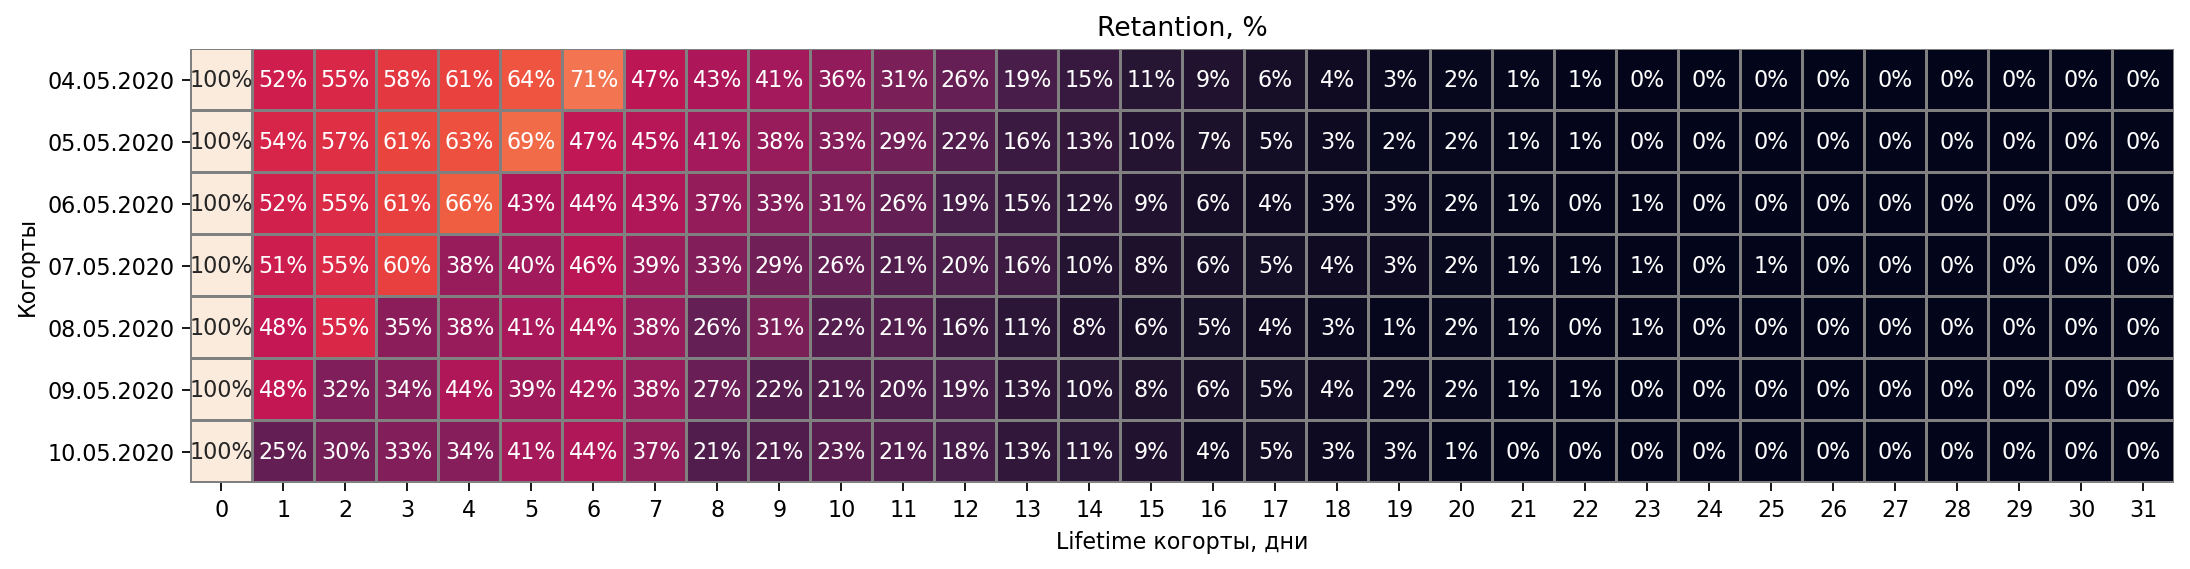

In [94]:
# Количество уникальных игроков
users_by_cohorts = cohorts.pivot_table(
    index='first_event_date',
    columns='day_of_activity',
    values='user_id',
).fillna(0).astype(int)

# отнесение к первому дню когорты
users_by_cohorts_perc = users_by_cohorts.div(users_by_cohorts[0], axis=0)

# Строим тепловую карту
plt.figure(figsize = (16,5))

sns.heatmap(
    users_by_cohorts_perc,
    annot=True, 
    fmt='.0%', 
    linewidths=1,
    linecolor='gray',
    yticklabels=users_by_cohorts.index.strftime('%d.%m.%Y'), 
    robust=True,
    square=True,
    cbar=0
)
plt.yticks(rotation=0) 
plt.title('Retantion, %')
plt.xlabel('Lifetime когорты, дни')
plt.ylabel('Когорты')
plt.show()

**Выводы:**
- В первые 6 дней жизни уровень удержания растет:
  - Вероятно, что отчасти это связано, с проведением маркетинговой кампании. Посмотрим это ниже
  - Через 12 дней уровень удержания снижается до менее 20% 

### 1.5. Расчет маркетинговых показателей

In [95]:
# общие затраты на маркетинг
ad_costs_sum = ad_costs.groupby('source')['cost'].sum().to_frame()
ad_costs_sum

# источники трафика игроков 
ad_efficiency = user_source.groupby('source')['user_id'].count().to_frame()
ad_efficiency

# свод датафрейма с затратами на привлечение пользователей
ad_result = ad_costs_sum.merge(
    ad_efficiency,
    left_index=True,
    right_index=True
)
ad_result.columns = ['cost', 'users']
ad_result.reset_index(inplace=True)

# cтоимость привлечения одного пользователя
ad_result['cost_per_user'] = ad_result['cost'] / ad_result['users']
ad_result = ad_result.sort_values('cost_per_user',ascending=False)
ad_result

,source,cost,users,cost_per_user
0,facebook_ads,"2,140.9",2726,0.8
1,instagram_new_adverts,"2,161.4",3347,0.6
2,yandex_direct,"2,233.1",4817,0.5
3,youtube_channel_reklama,"1,068.1",2686,0.4


## 2. Исследовательский анализ данных

### 2.1 Анализ маркетинговых затрат по источникам

In [96]:
print("Общие расходы на маркетинг: {:.0f} ".format(ad_costs['cost'].sum()))

Общие расходы на маркетинг: 7604 


##### Посмотроим график динамики расходов на маркетинг

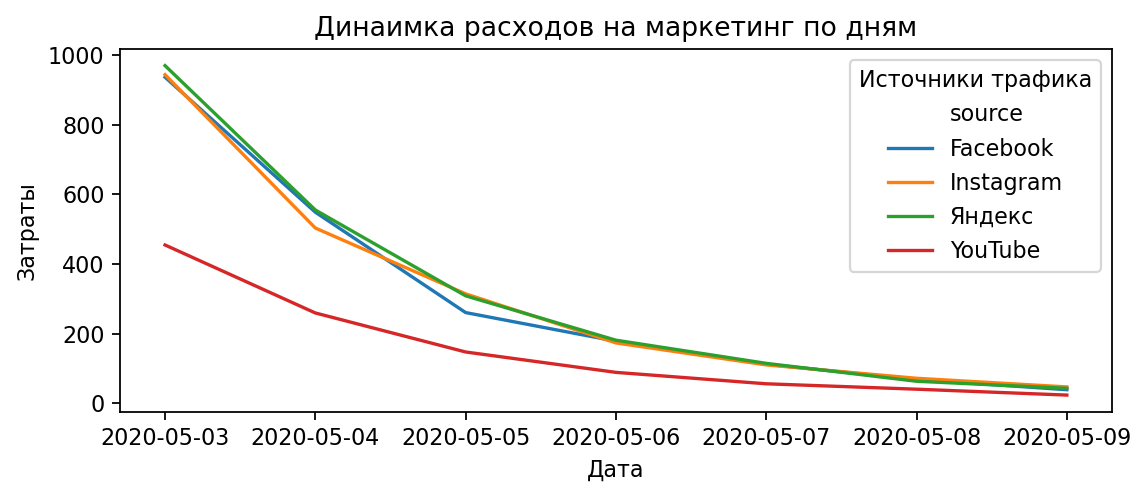

In [97]:
# Сделаем плоскую таблицу для построения графика
ad_costs_for_graph = ad_costs.pivot_table(index=['date','source'], values='cost', aggfunc='sum').reset_index()

#Сделаем словарь для ленегды
ad_source_name = {
    "facebook_ads": "Facebook",
    "instagram_new_adverts": "Instagram",
    "yandex_direct": "Яндекс",
    "youtube_channel_reklama": "YouTube",}

ad_costs_for_graph['source'] = ad_costs_for_graph['source'].map(ad_source_name)

# Строим график
plt.figure(figsize=(8,3))
sns.lineplot(data = ad_costs_for_graph, x = 'date', y ='cost', hue ='source')
plt.title('Динаимка расходов на маркетинг по дням')
plt.ylabel('Затраты')
plt.xlabel('Дата')
plt.legend(title='Источники трафика',
    loc='upper right'
)
plt.show()
# не понимаю как убрать слово source

### 2.2 Затраты на привлечение пользователей по источникам

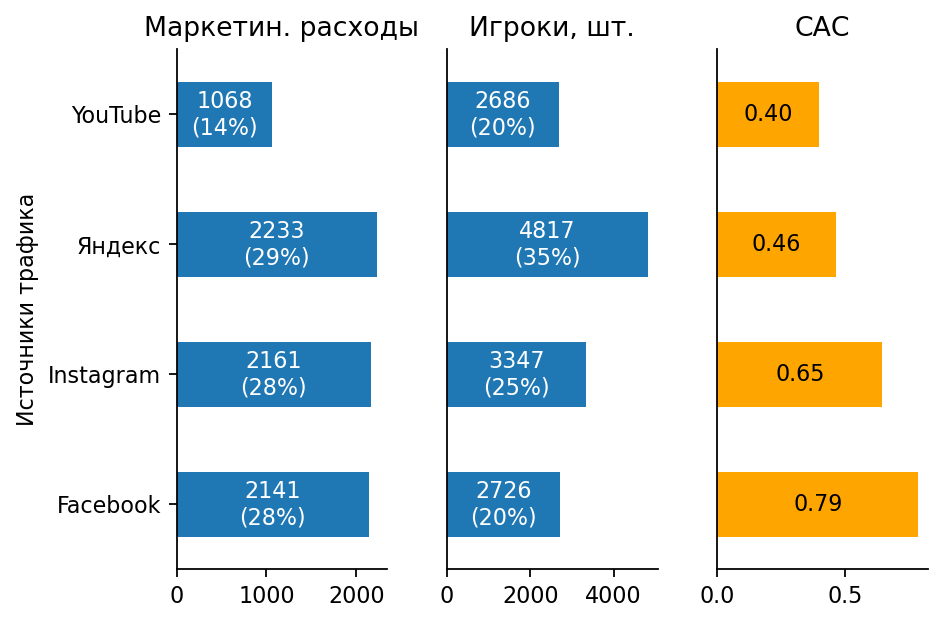

In [98]:
# График распределения открытия сессий
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

g1 = ad_result.cost.plot.barh(ax=ax1)
g2 = ad_result.users.plot.barh(ax=ax2)
g3 = ad_result.cost_per_user.plot.barh(ax=ax3, color='orange',)
ax1.set_title('Маркетин. расходы')#, weight='bold')
ax2.set_title('Игроки, шт.')#, weight='bold')
ax3.set_title('САС')#, weight='bold')


ax1.set(
#    title='', 
    ylabel='Источники трафика',
    xlabel=''
)

ax1.set_yticklabels([ad_source_name[x] for x in ad_result.source])
ax2.set_yticks([])
ax3.set_yticks([])

for i, value in enumerate(ad_result.iterrows()):
    ax1.text(
            value[1]['cost']/2, i,
            '{:.0f}\n({:.0%})'.format(value[1]['cost'] , value[1]['cost']/ad_result['cost'].sum()),
            ha='center', va='center', color='white'

        )
    ax2.text(
            value[1]['users']/2, i,
        '{:.0f}\n({:.0%})'.format(value[1]['users'] , value[1]['users']/ad_result['users'].sum()),
            ha='center', va='center', color='white'

        )
    
    ax3.text(
            value[1]['cost_per_user']/2, i,
            '{:.2f}'.format(value[1]['cost_per_user']),
            ha='center', va='center', color='black'

        )

sns.despine()
plt.grid(False)
plt.tight_layout()
plt.show()

**Выводы:**
- Бюджет распределен пропорционально за исключением YouTube, на который потрачено меньше всего. Видимо нашей целевой аудитории там нет.
- С Ясндекса пришла пришло больше всего игроков, наверное целевая аудитория скорее всего русскоязычная. После идет Instagram и на третьем месте Facebook и Youtube с примерно одинаковым количеством игроков
- Наименьший показатель CAC по Youtube, что очень странно, обычно это самый дорогой канал в игровой индустрии с маленькой конверсией и как следствие высоким CAC
- Так как ЦА у нас русскоязычная, то ожидаемо, что Facebook будет самым дорогим каналом. Плюс скорее всего по возрасту наша аудитория может быть ближе к ВК, чем FB. Это может быть причина высыкого САС по данном источнику.

### 2.3 Анализ количества пользователей (MAU, DAU, когорный анализ и lifitime)

In [99]:
print("Кол-во пользователей, установивших игру: {} шт.".format(user_source.user_id.nunique()))
print("Кол-во пользователей, совершивших хотя бы одно действие: {} шт.".format(events.user_id.nunique()))

Кол-во пользователей, установивших игру: 13576 шт.
Кол-во пользователей, совершивших хотя бы одно действие: 13576 шт.


In [100]:
dau_avg = int(events.groupby('date').agg({'user_id': 'nunique'}).mean())
wau_avg = int(events.groupby('week').agg({'user_id': 'nunique'}).mean())

print('Среднее кол-во уникальных пользователей за анализируемый период:\n \
      - в день: {}\n \
      - в неделю: {}'.format(dau_avg, mau_avg))

Среднее кол-во уникальных пользователей за анализируемый период:
       - в день: 2884
       - в неделю: 6802


<Figure size 320x640 with 0 Axes>

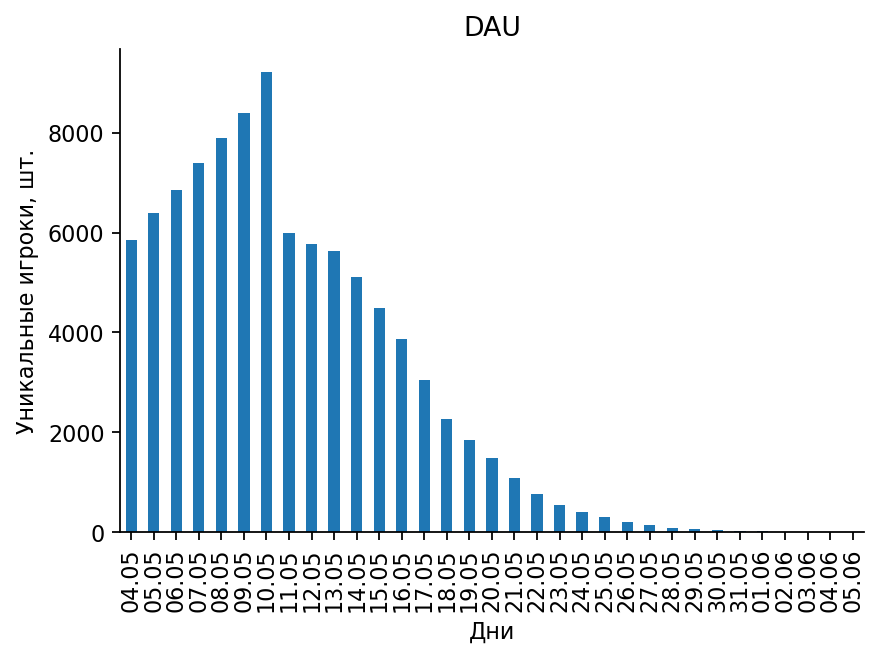

In [101]:
# датафрейм
events_dau = events.groupby('date').agg({'user_id': 'nunique'})

# график
plt.figure(figsize = (2,4))
events_dau.plot.bar(legend=False)
plt.gca().set_xticklabels(events_dau.index.strftime('%d.%m'), rotation=90)
plt.title('DAU')
plt.ylabel('Уникальные игроки, шт.')
plt.xlabel('Дни')
sns.despine()
plt.show()

<Figure size 2560x800 with 0 Axes>

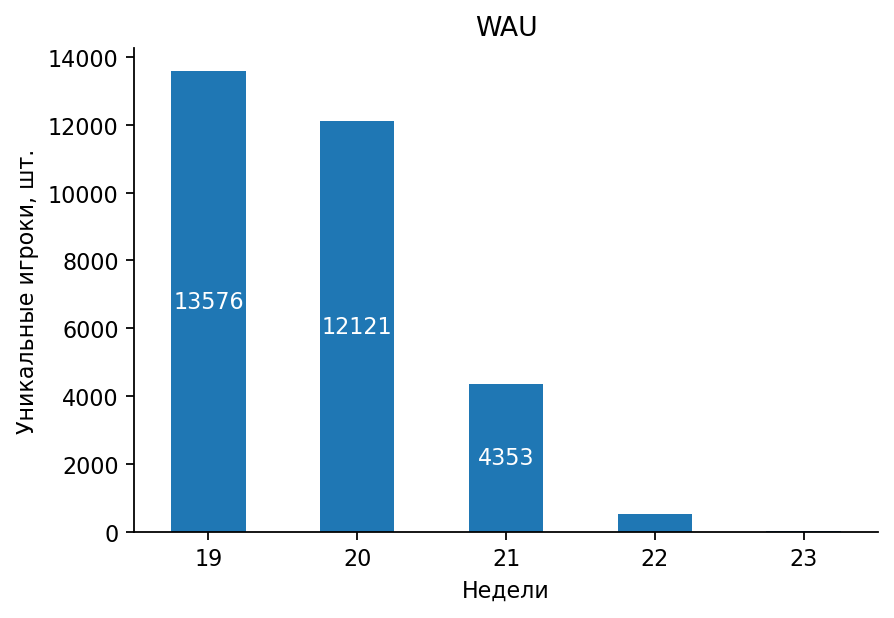

In [102]:
# датафрейм
events_wau = events.groupby('week').agg({'user_id': 'nunique'})

# график
plt.figure(figsize = (16,5))
events_wau.plot.bar(rot=0, legend=False)
plt.title('WAU')
plt.ylabel('Уникальные игроки, шт.')
plt.xlabel('Недели')
#plt.grid(axis='y')

for i, value in enumerate(events_wau.iterrows()):
    if value[1]['user_id'] < 1000:
        pass
    else:
        plt.gca().text(
            i, value[1]['user_id']/2,
            '{:.0f}'.format(value[1]['user_id']),
            ha='center', va='center', color='white'
        )
    
sns.despine()
plt.show()

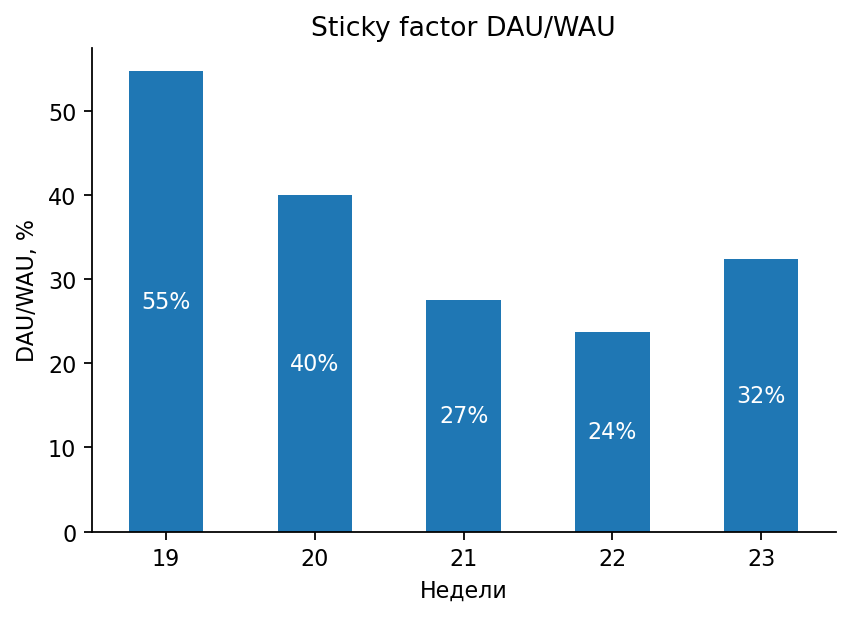

In [103]:
# датафрейм
sticky_wau_trend = ((events.groupby(['week', 'date']).agg({'user_id': 'nunique'}).reset_index()).groupby(
        ['week']).agg({'user_id': 'mean'}) / events_wau) * 100
sticky_wau_trend.plot.bar(legend=False, rot=0)

# график
plt.title('Sticky factor DAU/WAU')
plt.xlabel('Недели')
plt.ylabel('DAU/WAU, %')

for i, value in enumerate(sticky_wau_trend.iterrows()):
    plt.gca().text(
        i, value[1]['user_id']/2,
        '{:.0f}%'.format(value[1]['user_id']),
        ha='center', va='center', color='white'
    )

sns.despine()
plt.show()

**Выводы:**
- Все пользователи, которые установили игру, совершили хотя бы одно действие. Скорее всего у нас выгрузка только по пользователям, которые совершили хоть одно действие, а не по всем пользователям, которые скачали игры, т.к. слишком классные показатели.
- Первую неделю рост пользовательской базы обеспечивает маркетинговая кампания. Пиковое значение 10 тыс. пользователей в день приходится на 10 день - это последний день кампании. 
- Пик снижения пользователей происходит на третью неделю
- Также себя ведет и динамика Sticky factor DAU/WAU. Небольшое увеличение в конце связано с колебаниями небольших абсолютных значений.

## 3. Анализ влияния источника перехода в игру на поведение пользователя

### 3.1. Анализ поведения пользователей (по ключевым дейтсвиям) в зависимости от источника трафика

#### Кол-во построек по источникам трафика

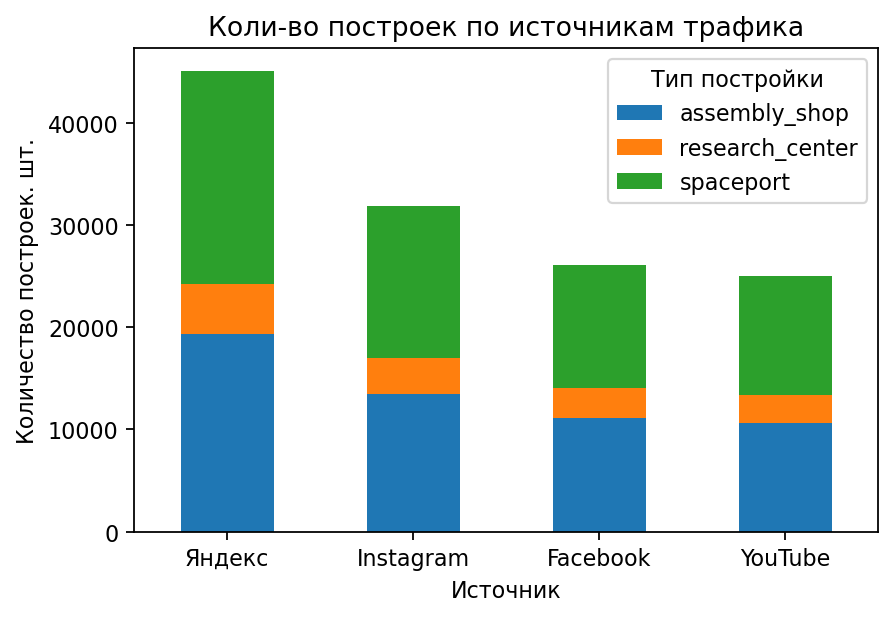

In [114]:
# Подготовим датафрейм
data_build_for_graph = events.pivot_table(
    index='source',
    columns='building_type',
    values='event_datetime',
    aggfunc='count',
)
data_build_for_graph['total'] = data_build_for_graph.sum(axis=1)
data_build_for_graph = data_build_for_graph.sort_values('total', ascending=False)


# Строим график
data_build_for_graph[['assembly_shop','research_center', 'spaceport'] ].plot.bar(stacked=True, rot=0)
plt.gca().set_xticklabels([ad_source_name[x] for x in buildings.index])


plt.title('Коли-во построек по источникам трафика')
plt.xlabel('Источник')
plt.ylabel('Количество построек. шт.')
plt.legend(title='Тип постройки')
plt.show()

#### Распределение кол-во построек по пользователям

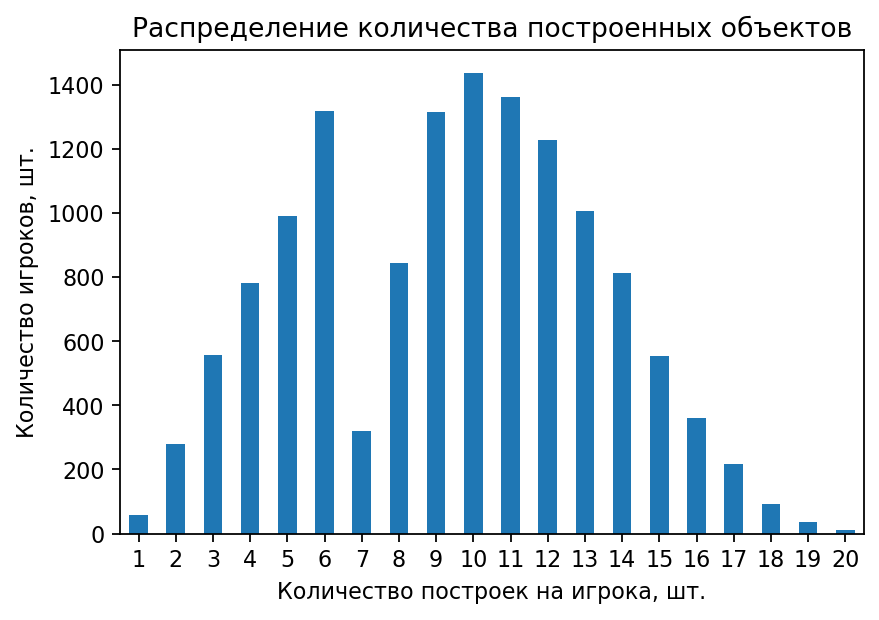

In [115]:
events.groupby('user_id')['building_type'].count().value_counts().sort_index().plot.bar(rot=0)
plt.title('Распределение количества построенных объектов')
plt.xlabel('Количество построек на игрока, шт.')
plt.ylabel('Количество игроков, шт.')
plt.show()

**Вывод:**
- Исходя из графика можно сделать предположение, что пользователи, которые не завершили первый уровень, ушли из игры после 6 постройки.
- Нужно сделать deep dive поведения пользователей на этом этапе и возможно ввести мотивирующие действия в игре для предотвращения ухода.

#### Время на завершение уровня 1

In [119]:
# Датафрем по пользователям, завершивших проект
users_finished_project = events.query('type_of_completion != "in_process" and \
project_type == "satellite_orbital_assembly"')[['user_id', 'type_of_completion','day_of_activity']].copy()

# Датафрейм по пользователям, победивших первого врага
users_won_first = events.query('type_of_completion == "won_first_enemy"').groupby(
    ['user_id','type_of_completion','day_of_activity'])['date'].last().reset_index().copy()
users_won_first.drop(columns=['date'], inplace=True)

# Сводный датафрейм
time_to_finish_stage1 = pd.concat([users_finished_project, users_won_first],ignore_index=True).reset_index(drop=True)

time_to_finish_stage1.head()

,user_id,type_of_completion,day_of_activity
0,c07b1c10-f477-44dc-81dc-ec82254b1347,built_project,9
1,65a92713-5969-48b1-8945-bfefa5063887,built_project,14
2,fa352362-d258-472c-b295-2796ccc39fa3,built_project,14
3,7b3b6554-7949-4065-9808-d6c79bdc2f58,built_project,10
4,b374304d-2f74-4cc1-a4e2-500da44a06c7,built_project,10


[Text(0, 0, 'Проект выполнен'), Text(0, 0, 'Победа над первым врагом')]

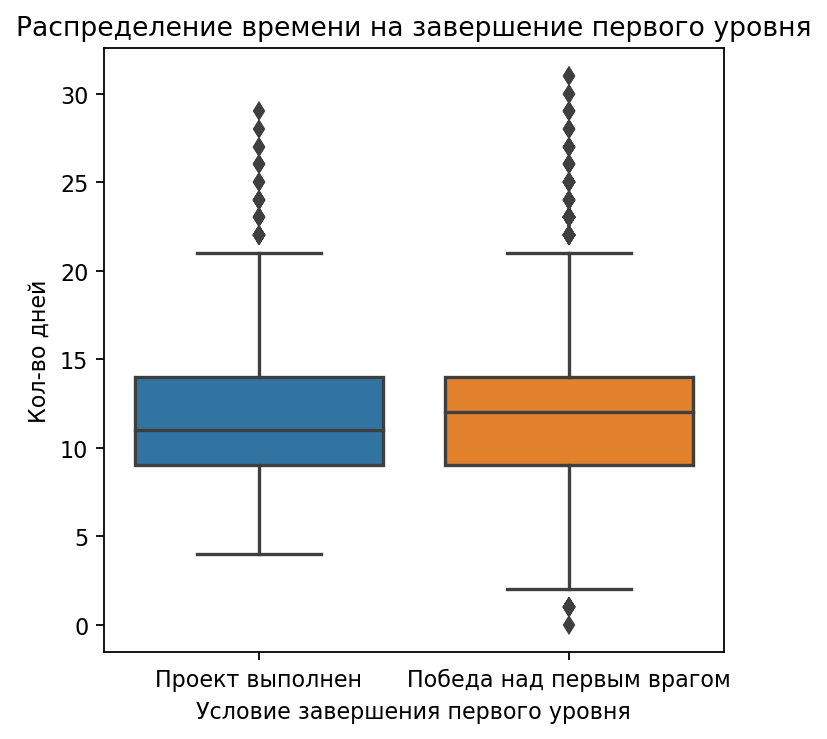

In [132]:
# Построим ящик с усами для распределения времени на завершение уровня 1

plt.figure(figsize=(5,5))

sns.boxplot(
    y='day_of_activity',
    x="type_of_completion", 
    data=time_to_finish_stage1,)
plt.title('Распределение времени на завершение первого уровня')
plt.ylabel('Кол-во дней')
plt.xlabel('Условие завершения первого уровня')
plt.gca().set_xticklabels(['Проект выполнен', 'Победа над первым врагом'])



##### Посмотрим на описательную статистику

In [135]:

users_finished_project.describe()

,day_of_activity
count,"1,866.0"
mean,11.8
std,3.7
min,4.0
25%,9.0
50%,11.0
75%,14.0
max,29.0


In [136]:
time_to_finish_stage1.describe()

,day_of_activity
count,"7,683.0"
mean,11.8
std,4.0
min,0.0
25%,9.0
50%,11.0
75%,14.0
max,31.0


**Вывыды:**

- В среднем, пользователи завершают первый уровень за 11,8 дней независимо от условия завершения.
- Медианное значение по кол-ву дней для завершения первого уровня за счет проекта составляет 11 дней, а за счет первой победы  12 дней.
- Стандартное отклонение времени на завершение уровня 1 по условию победы больше, чем через постройку проекта. Возможно, что нет баланса между слабыми и сильными противниками.

#### Распределение количества построек в зависимости от источника

In [185]:
# свод игроков, завершивших уровень 1
user_finished_stage_1 = events.query('type_of_completion != "in_process"')[['user_id', 'source', 'day_of_activity']]
user_finished_stage_1.set_index('user_id', inplace=True)

user_finished_stage_1['source'] = user_finished_stage_1['source'].map(ad_source_name)

In [186]:
list_of_source = ['Instagram','Facebook','Яндекс','YouTube']
for i in list_of_source:
    print('==== Описательная статистика по ',i, '====')
    display(user_finished_stage_1.query('source == @i').describe())
    print(' ')

==== Описательная статистика по  Instagram ====


,day_of_activity
count,"1,942.0"
mean,11.9
std,3.9
min,0.0
25%,9.0
50%,11.0
75%,14.0
max,30.0


 
==== Описательная статистика по  Facebook ====


,day_of_activity
count,"1,541.0"
mean,11.8
std,4.0
min,1.0
25%,9.0
50%,11.0
75%,14.0
max,30.0


 
==== Описательная статистика по  Яндекс ====


,day_of_activity
count,"2,662.0"
mean,11.7
std,4.0
min,1.0
25%,9.0
50%,11.0
75%,14.0
max,31.0


 
==== Описательная статистика по  YouTube ====


,day_of_activity
count,"1,538.0"
mean,11.9
std,3.9
min,1.0
25%,9.0
50%,11.5
75%,14.0
max,27.0


Text(0.5, 0, 'Источник')

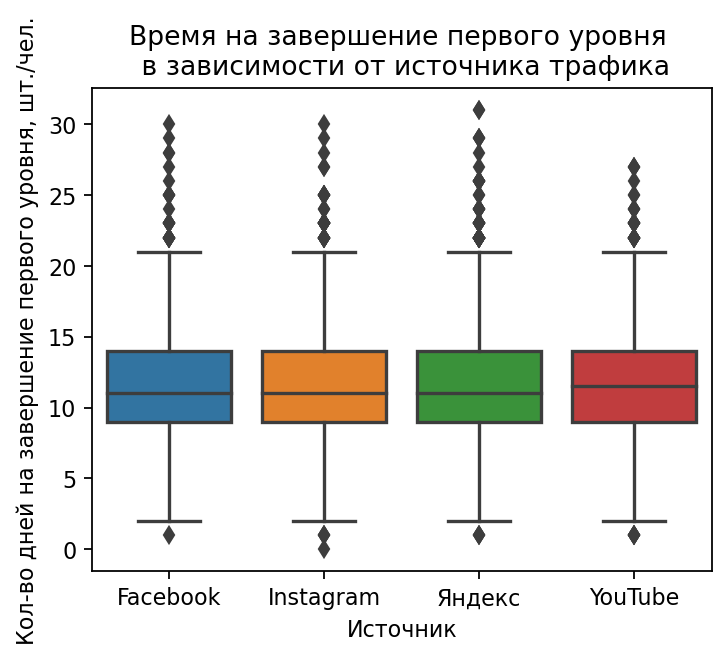

In [188]:
#Построим ящик с усами
plt.figure(figsize=(5,4))

sns.boxplot(
    y='day_of_activity',
    x='source', 
    data=user_finished_stage_1,
)
plt.title('Время на завершение первого уровня \n в зависимости от источника трафика')
plt.ylabel('Кол-во дней на завершение первого уровня, шт./чел.')
plt.xlabel('Источник')


## 4. Проверка статистических гипотез

### 4.1. Проверка гипотезы: время завершения уровня различается в зависимости способа прохождения

Различие времени завершения уровня в зависимости способа прохождения через реализацию проекта или через победу над первым игроком должно быть проверено через гипотезу о равенстве средних двух генеральных совокупностей:

- **H0**: время завершения уровня не зависит от способа прохождения (среднее время через реализацию проекта равно среднему времени через победу над первым игроком).
- **H1**: время завершения уровня зависит от способа прохождения.

In [191]:
# Время завершения первого уровня пользователей из Источника_1

time_built_project = time_to_finish_stage1.query('type_of_completion == "built_project"')['day_of_activity']

# Время завершения первого уровня пользователей из Источника_2

time_won_first = time_to_finish_stage1.query('type_of_completion == "won_first_enemy"')['day_of_activity']


# критический уровень статистической значимости
alpha = .05 

results = st.ttest_ind(
    time_built_project, 
    time_won_first)

print("Среднее время завершения первого уровня:")
print("  - Выполнение проекта, дни: {:.1f}.".format(time_built_project.mean()))
print("  - Первая победа над врагом, дни: {:.1f}.".format(time_won_first.mean()))
print()

print('p-значение: {:.3f}'.format(results.pvalue))

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу. Время завершения уровня зависит от способа прохождения.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Время завершения первого уровня не зависит от способа прохождения.")

Среднее время завершения первого уровня:
  - Выполнение проекта, дни: 11.8.
  - Первая победа над врагом, дни: 11.8.

p-значение: 0.846
Не получилось отвергнуть нулевую гипотезу. Время завершения первого уровня не зависит от способа прохождения.


### 4.2. Проверка гипотезы: собственная гипотеза (кол-во построек различается в зависимости от источника трафика)

Различие количества построек в зависимости от источника трафика должно быть проверено через гипотезу о равенстве средних двух генеральных совокупностей:

- **H0**: количество построек не зависит от источника трафика (среднее кол-во построек по источнику_1 равно среднему кол-во по источнику_2).
- **H1**: количество построек зависит от источника трафика.

In [216]:
def z_value(source_name_1,source_name_2):
    
    # Время завершения первого уровня пользователями из Источника_1
    source_1 = user_finished_stage_1.query('source == @source_name_1')['day_of_activity']

    # Время завершения первого уровня пользователями из Источника_2
    source_2 = user_finished_stage_1.query('source == @source_name_2')['day_of_activity']


    # критический уровень статистической значимости
    alpha = .05 

    results = st.ttest_ind(source_1, source_2)

    print('Проверка равенства ср. времени прохождения уровня 1 пользователями, пришедших из ', source_name_1,'и', source_name_2)
    print()
    print("Среднее время завершения первого уровня:")
    print("  - Пользователей из источника {}, дни: {:.1f}.".format(source_name_1,source_1.mean()))
    print("  - Пользователей из источника {}, дни: {:.1f}.".format(source_name_2,source_2.mean()))
    print()


    print('p-значение: {:.3f}'.format(results.pvalue))
    print()
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу. Время завершения уровня зависит от источника трафика.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу. Время завершения первого уровня не зависит от источника трафика.")
    print('===========================================================================================================')


In [217]:
for source_name_1 in list_of_source:
    for source_name_2 in list_of_source:
        if(source_name_1 == source_name_2):
            continue
        else:
            z_value(source_name_1,source_name_2)
            print('')

Проверка равенства ср. времени прохождения уровня 1 пользователями, пришедших из  Instagram и Facebook

Среднее время завершения первого уровня:
  - Пользователей из источника Instagram, дни: 11.9.
  - Пользователей из источника Facebook, дни: 11.8.

p-значение: 0.679

Не получилось отвергнуть нулевую гипотезу. Время завершения первого уровня не зависит от источника трафика.

Проверка равенства ср. времени прохождения уровня 1 пользователями, пришедших из  Instagram и Яндекс

Среднее время завершения первого уровня:
  - Пользователей из источника Instagram, дни: 11.9.
  - Пользователей из источника Яндекс, дни: 11.7.

p-значение: 0.271

Не получилось отвергнуть нулевую гипотезу. Время завершения первого уровня не зависит от источника трафика.

Проверка равенства ср. времени прохождения уровня 1 пользователями, пришедших из  Instagram и YouTube

Среднее время завершения первого уровня:
  - Пользователей из источника Instagram, дни: 11.9.
  - Пользователей из источника YouTube, дни: 11.9

**Вывод:**
- Время прохождения первого уровня не зависит от источника трафика

## 5. Выводы и рекомендации


- Маркетинговая кампания проводилась с 03.05.2020 по 09.05.2020.  
- Ее период выпадает на майские праздники, когда люди обычно на отдыхе и могут меньше играть в игры

**Источники**
- С Яндекс пришла наибольшая доля игроков. На втором месте Instagram, далее идут Facebook и Youtube.
- ЦА капмпании русскоговорящая из-за большого трафика с Яндекса.
- Минимальные САС у Youtube — 0,4, что довольно странно, а самый дорогой у Facebook, что ожидаемо, если наша ЦА молодые люди.
- Необходимо скорректировать маркетинговую стратегию продвижения, уменьшив вливания в Facebook и перекинуть их на Яндекс.


**Кол-во пользователей**
- Среднее количество уникальных пользователей за исследуемый период:
    - в день: 2 884
    - в неделю: 6 120
- После 12 дня в когортах активны не более 20% первоначального количества игроков.
- Около половины игроков завершили уровень 1:
- Пользователи, которые не завершили первый уровень, ушли из игры до того как сделают 7 построек. 
- Нужно сделать deep dive поведения пользователей на этом этапе и возможно ввести мотивирующие действия в игре для предотвращения ухода.

**Время в игре**
- Среднее время до завершения уровня 1:
  - Победа над врагом, дни: 12.
  - Реализация проекта, дни: 12.
- Гипотеза о равенстве времени завершения уровня 1 в зависимости от способа прохождения подтверждены.
- Стандартное отклонение времени на завершение уровня 1 по условию победы больше, чем через постройку проекта. Вероятно, слабым игрокам попадаются слишком сильные противники и наоборот.  
- Рекомендовал был провести анализ балансировки и подбора противников по уровню прокаченности


**Постройки в игре**

- Среднее количество построек до завершения первого уровня:
  - Для выполнивших первую победу над врагом: 10 шт.
  - Для тех, чтобы Реализация проекта: 13 шт.
- Подтвержденная статистическая гипотеза: количество построек зависит от способа прохождения уровня.
- Вероятно, что баланс построек на завершение уровня 1 не выдержан. Игроки смогут обойти систему прокачки и покупки зданий через победу над врагом.  
- Необходимо сбалансировать игровую систему до введения монетизации.__

    

## Ссылка на презентацию
Пока не делал, чтобы точно понять, что с цифрами и выводами все верно.
<a id = "presentation"></a>
[В оглавление](#index)